In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
import os
import torch

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_arrow_points(center, angle, length):
    angle = np.deg2rad(angle)
    x1 = int(center[0] + length/2 * np.cos(angle))
    y1 = int(center[1] + length/2 * np.sin(angle))
    x2 = int(center[0] - length/2 * np.cos(angle))
    y2 = int(center[1] - length/2 * np.sin(angle))
    return (x1, y1), (x2, y2)

def draw_arrow(image, center, angle, length=50, color=(128, 0, 255), thickness=2):
    point1, point2 = get_arrow_points(center, angle, length)
    return cv2.arrowedLine(image, point1, point2, color, thickness)

arrows = {0: lambda img, length: draw_arrow(img, (180, 250), 30, length),
          1: lambda img, length: draw_arrow(img, (310, 200), 150, length),
          2: lambda img, length: draw_arrow(img, (205, 205), 210, length),
          3: lambda img, length: draw_arrow(img, (195, 350), 210, length),
          4: lambda img, length: draw_arrow(img, (215, 170), 345, length),
          5: lambda img, length: draw_arrow(img, (295, 165), 15, length)}

def draw_arrows(image, label, scale=10):
    image = np.array(image)
    for i, value in enumerate(label):
        if value != 0:
            image = arrows[i](image, value * scale)
    return Image.fromarray(image)

In [13]:
def show_annoteted_image(index, scale=10):
    image = Image.open(f"/mnt/data/pose_estimation/{index}_0.jpg")
    label = np.load(f"/mnt/data/pose_estimation/{index}.npy")
    display(draw_arrows(image, label, scale))

tensor([-6.,  3.,  0.,  0.,  0.,  0.])
tensor([-6.,  0.,  0.,  0.,  0.,  0.])


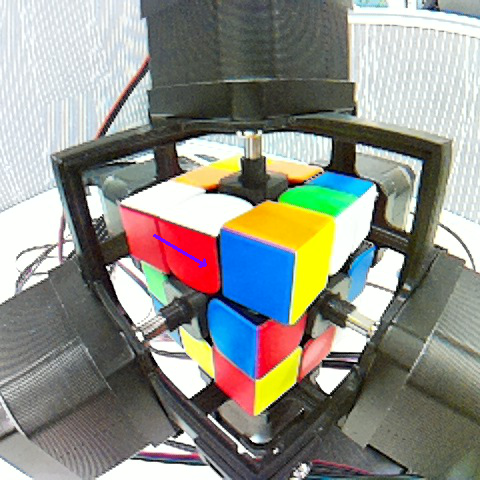

In [3]:
files = [f for f in os.listdir('pose_estimation') if f.endswith('.npy')]
file = np.random.choice(files).split('.')[0]
image = Image.open(f'pose_estimation/{file}_0.jpg')
label = torch.tensor(np.load(f'pose_estimation/{file}.npy')).float()
print(label)
label = label * (torch.softmax(torch.abs(label), dim=0)>0.3)
print(label)
draw_arrows(image, label)

In [4]:
files = [f for f in os.listdir('/mnt/data/pose_estimation') if f.endswith('.npy')]
labels = [np.load(f'/mnt/data/pose_estimation/{f}') for f in files]
labels = torch.tensor(labels).float()

/tmp/ipykernel_47353/3860595297.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/torch/csrc/utils/tensor_new.cpp:201.)
  labels = torch.tensor(labels).float()


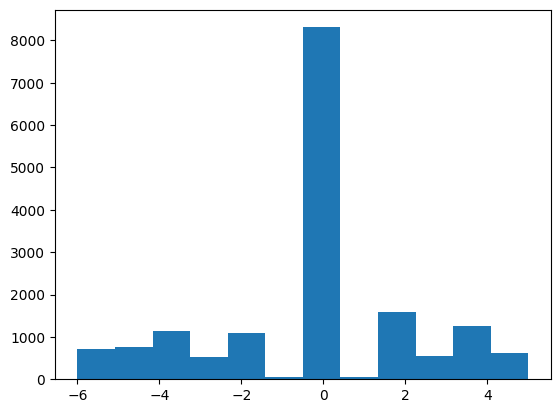

In [5]:
plt.hist(labels.numpy().flatten(), bins=12);

In [4]:
from dataset import Dataset
from model import PoseEstimator

In [5]:
dataset = Dataset(resolution=(480, 480), directory='/mnt/data/', model_type='pose_estimation')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PoseEstimator(input_shape = (3, 480, 480), pool_list = [True, True, True, True, False, False, True, True])
model.load_state_dict(torch.load('/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeml/code/rubiks-cube/server/models/PoseEstimator_whole-fog-35_best.pth'))
model.to(device);

In [8]:
from torch.utils.data import DataLoader
from tqdm import tqdm

In [9]:
results = {}
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size)
for i, batch in enumerate(tqdm(dataloader)):
    [images], labels = batch
    preds = model(images.to(device))
    labels = model._prepare_labels(labels.to(device))
    for j in range(preds.size(0)):
        acc, precision, recall, f1 = model._calculate_metrics(preds[j], labels[j])
        acc = acc.item()
        precision = precision.item()
        recall = recall.item()
        f1 = f1.item()
        results[i * batch_size + j] = {'acc': acc, 'precision': precision, 'recall': recall, 'f1': f1}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:41<00:00,  1.89s/it]


In [7]:
img = Image.open('fixed_rgb.jpg')
img = torch.tensor(np.array(img))
img = img.permute(2, 0, 1).float() / 255
img = img.unsqueeze(0)
pred = model(img.to(device))
pred

tensor([[ 0.1399, -1.6142, -2.2191,  1.5529, -0.2862,  0.3627,  2.2743, -0.5158,
          0.1898, -0.2577, -0.1261,  0.5183]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [10]:
def convert_label(pred):
    label = np.zeros(6)
    for i in range(6):
        if pred[i] > pred[i+1]:
            label[i] = pred[i]
        else:
            label[i] = -pred[i+1]
    return label


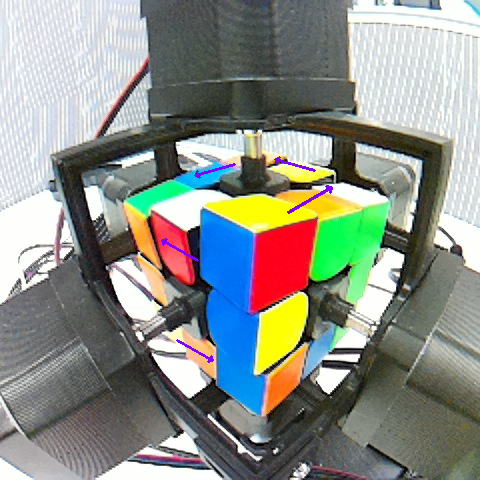

In [19]:
show_annoteted_image(444, scale=10)

<BarContainer object of 12 artists>

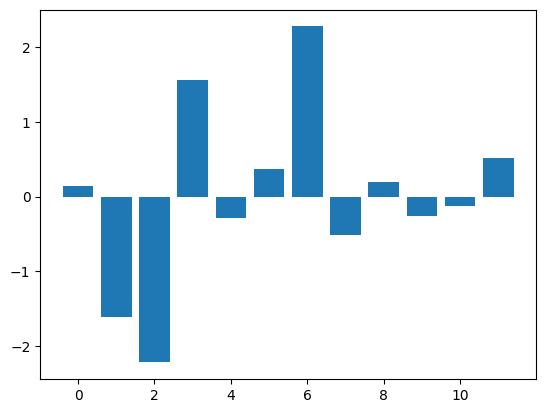

In [8]:
plt.bar(np.arange(12), pred[0].detach().cpu().numpy())

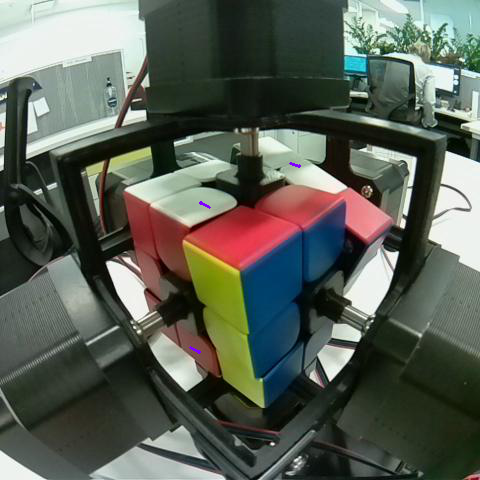

In [12]:
img = Image.open('fixed_rgb.jpg')
label = pred.cpu().detach().numpy().flatten() > 0.5
label = convert_label(label.astype(int))
draw_arrows(img, label)

In [32]:
torch.cuda.empty_cache()

In [10]:
import pandas as pd
df = pd.DataFrame(results).T

In [10]:
from utils import ModelWarehouse
connection_string = os.environ['blob_conn_string']
container = os.environ['blob_container']
model_warehouse = ModelWarehouse(connection_string, container)

In [12]:
model_warehouse.upload_model('models/PoseEstimator_usual-leaf-31_best.pth', 'PoseEstimator_usual-leaf-31_best.pth')

In [11]:
df.sort_values('f1', ascending=True)

,acc,precision,recall,f1
2116,0.069444,0.0,0.0,0.000000
1108,0.076389,0.0,0.0,0.000000
1112,0.083333,0.0,0.0,0.000000
1123,0.069444,0.0,0.0,0.000000
2329,0.069444,0.0,0.0,0.000000
...,...,...,...,...
729,0.083333,1.0,1.0,0.999999
1047,0.083333,1.0,1.0,0.999999
1580,0.083333,1.0,1.0,0.999999
2571,0.083333,1.0,1.0,0.999999


Bad pipe message: %s [b'S)H\x18\x00^\xf5+\x0fF\xd6\x8a*t\xc9\xbdz\xfe\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00', b"\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07"]
Bad pipe message: %s [b'\x08\t\x08\n\x08\x0b\x08']
Bad pipe message: %s [b'\x05\x08\x06']
Bad pipe message: %s [b'\x05\x01\x06', b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'', b'\x02']
Bad pipe message: %s [b'\x05\x02\x06']
Bad pipe message: %s [b'\x9d\

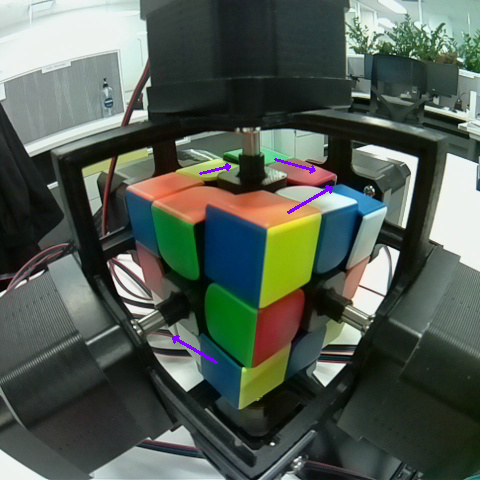

In [9]:
show_annoteted_image(1047)